# Machine Learning Coursework, pt. 1 
## by Grzegorz Rybak

# Step 0: loading the IRIS dataset from the sci-kit datasets

In [3]:
# Load the IRIS dataset, as in the labs
from sklearn import datasets

iris = datasets.load_iris()
X=iris.data
y=iris.target
mySeed=1234567

## 1. Exploratory Data Analysis

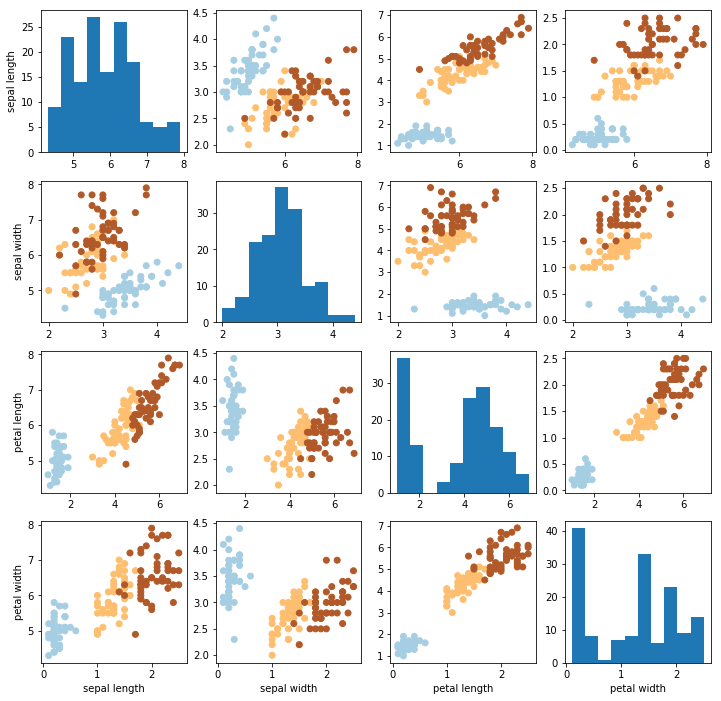

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

def myplotGrid(X,y):
    fig = plt.figure(figsize=(12,12))
    subPlotCount = 0
    labels = ['sepal length', 'sepal width', 'petal length', 'petal width']
    for i in range(0,4):
        for j in range(0,4):
            subPlotCount += 1 
            ax = fig.add_subplot(4,4,subPlotCount)
            if i==3:
                ax.set_xlabel(labels[j])
            if j==0:
                ax.set_ylabel(labels[i])
            if j==i:
                ax.hist(X[:,j])
                continue
            ax.scatter(X[:, i], X[:, j], c=y, cmap=plt.cm.Paired)
myplotGrid(X,y)

### 1.2. Exploratory Data Analysis under noise

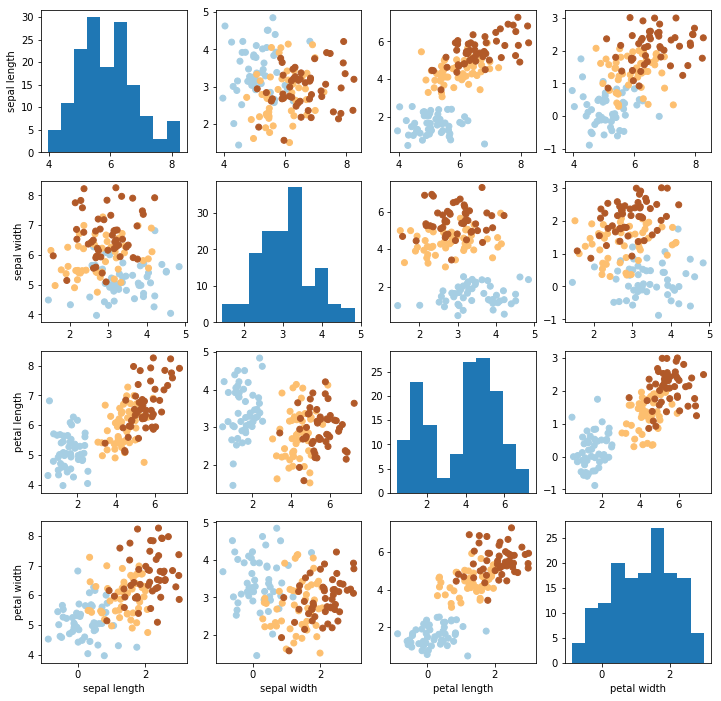

In [20]:
import numpy as np

np.random.seed(mySeed)
XN=X+np.random.normal(0,0.5,X.shape)
myplotGrid(XN,y)

## 2. Implementing kNN
My "k-Nearest Neighbour classification" algorithm is a class instead of a function in order to greatly increase the readability and structure of the code. See code comments for any further details. 

In [21]:
# I need this operator import to perform  a correct sorting in my getNeighbours implementation. 
from operator import itemgetter

class mykNN:
    """For the kwargs (keyword argument) called '**options' please provide: 'num_of_neighbours' for the nns and 'dist_metric' for the type of distance to use. Available dist_metric choices: 'euclidean', 'manhattan'. Params default to: 'num_of_neighbours':10, 'dist_metric': 'euclidean' """
    def __init__(self, X,y,X_,**options):
        self.X = X 
        self.y = y
        self.X_ = X_ 
        if "num_of_neighbours" not in options:
            self.num_of_neighbours = 10
        else:
            self.num_of_neighbours = options.get("num_of_neighbours")
        if "dist_metric" not in options:
            self.dist_metric = 'euclidean'
        else:
            self.dist_metric = options.get("dist_metric")
        self.predicted_labels = np.zeros((0), dtype='int32')
        for index,_ in enumerate(self.X_):
            x_test_neighbours_indexes = self.getNeighbours(index)
            predicted_label = self.assignLabel(x_test_neighbours_indexes)
            self.predicted_labels = np.append(self.predicted_labels, predicted_label)
            
    # IDEA: I implemented the distances functions as static functions because they don't need any of the class' variables
    # Thus, with this design they could be freely used without instantiating the class.       
    @staticmethod    
    def euclideanDistance(in1,in2):
        return np.linalg.norm(in1 - in2)

    @staticmethod    
    def manhattanDistance(in1,in2):
        # DISCLAIMER: I found out that we can just add '1' as another argument to make the manhattan distance out of the calc for Euclidean distance on stackOverflow:
        # https://stackoverflow.com/questions/49894734/pearson-vs-euclidean-vs-manhattan-results
        return np.linalg.norm(in1 - in2, 1)
        # NOTE: this is non-numpy way of doing it the above: 
        # manh_dist = 0
        # for index,featureA in enumerate(in1):
        #     featureB =  in2[index]
        #     manh_dist += abs(featureA - featureB)
        # return manh_dist

    def getNeighbours(self, x_test_index): 
        distances = dict()
        T = len(self.X) # T is number of data (i.e. length of our X data pieces array)
        distance_measures = {'euclidean': self.euclideanDistance, 'manhattan': self.manhattanDistance}
        distance_measure_chosen = self.dist_metric
        if distance_measure_chosen not in distance_measures:
             distance_measure_chosen = 'euclidean'
        for num in range(T):
            # the condition belows ensures that we never compare distance of the exactly same point.
            # (which shouldn't happen by default as train and test data are separated but is a good extra check)             
            if np.array_equal(self.X_[x_test_index], self.X[num]):
                continue
            dist = distance_measures[distance_measure_chosen](self.X_[x_test_index],self.X[num])
            distances[num] = dist 
        sorted_dists = list()
        # IDEA: If we only put "k" instead of "k,_" we would get tuples of (index,distance), but we only need the indexes of the closest data items so thus I use "_" according to PEP8 to identify value to be discarded over the iteration 
        for k,_ in sorted(distances.items(), key=itemgetter(1)):
            sorted_dists.append(k)
        neighbours = []
        for i in range(self.num_of_neighbours):
            neighbours.append(sorted_dists[i])
        return neighbours # indices of n-nearest neighbours in training data

    def assignLabel(self,x_test_neighbours_indexes):
        if len(x_test_neighbours_indexes) == 1:
            return self.y[x_test_neighbours_indexes]
        else:
            # IDEA: First 4 lines below create a dictionary of all possible classes.
            classes = dict()
            types_of_classes = np.unique(y)
            for each_class in types_of_classes:
                 classes[each_class] = 0
            for index in x_test_neighbours_indexes:
                classes[self.y[index]] += 1
            most_occuring_label,num_of_times_occuring = -1, 0
            for key, value in classes.items():
                if value > num_of_times_occuring: 
                    num_of_times_occuring = value 
                    most_occuring_label = key
        return most_occuring_label # label assigned to test point x_
    
    # PSEUDOCODE FOR QUESTION 3b 
    # def breakTie(x_test_neighbours_indexes):
    #     # IDEA: if the number of the indexes is even ... 
    #     if len(x_test_neighbours_indexes) % 2 == 0:
    #         distances = []
    #         # IDEA: We check their distances again, this time only 
    #         # measuring the petal width and length 'closeness' with the test datapoint  
    #         for each_neighbour_index in x_test_neighbours_indexes:
    #             neighbour_data = X[each_neighbour_index] 
    #             dist = euclideanDistance(test_datapoint[2:],neighbour_data[2:])
    #             # IDEA: we take a slice [2:] as the petal length and width are  
    #             # the 3rd and 4th value in the array (thus afer 2nd index)
    #             distances.append([dist,each_neighbour_index])
    #         # IDEA: we add them to an array of distances and sort that array...
    #         distances = sorted(distances)
    #         closest_neighbour = distances[0]
    #         return y[closest_neighbour] # IDEA: ..And we return the label of the closest  
    #                 # neighbour when measuring only petal width and length distance.

    def __repr__(self):
        return str(self.__call__())

    def __call__(self):
        return self.predicted_labels

#### Disclaimer: 
Please note for the idea how to implement the getNeighbours function behaviour I followed section 3. of the following tutorial: https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/

## 3. Nested Cross-validation using my implementation of KNN

## 3.1. My function for printing the accuracy

In [22]:
def myAccuracy(y_test,y_pred):
    correct= np.where(y_test == y_pred) # change this line
    accuracy = len(correct[0])/len(y_test) 
    return accuracy

## 3.2. My function for creating a confusion matrix 

In [23]:
def myConfMat(y_test,y_pred,classno):
    C=np.zeros((classno,classno),dtype='int') # initialize the confusion matrix to zeros
    #loop through all results and update the confusion matrix
    for truth,prediction in zip(y_test,y_pred):
        C[truth,prediction] += 1 
    return C

##  3.3. myNestedCrossVal function 

In [24]:
import itertools
def myNestedCrossVal(X,y,foldK,nns,dists,mySeed):
    np.random.seed(mySeed)
    accuracy_fold=[]
    all_y_tests = []
    all_y_pred = []
    indices = np.random.permutation(X.shape[0])

    bins=np.array_split(indices, foldK)

    assert(foldK==len(bins))
    
    for i in range(0,foldK):
        foldTrain=[] # list to save current indices for training
        foldTest=[]  # list to save current indices for testing
        foldVal=[]    # list to save current indices for validation

        #loop through all bins, take bin i for testing, the next bin for validation, and the rest for training
        for index,indicesArr in enumerate(bins):
            if index == i:
                foldTest = indicesArr.tolist()
            elif index == (i+1)%foldK:
                foldVal = indicesArr.tolist()
            else:
                foldTrain.append(indicesArr.tolist())

        foldTrain = list(itertools.chain(*foldTrain))
        x_train= np.asarray ([X[x] for x in foldTrain])        
        y_train=np.asarray ( [y[x] for x in foldTrain])        
        x_test= np.asarray ([X[x] for x in foldTest])        
        y_test= np.asarray ([y[x] for x in foldTest]) 
        x_val= np.asarray ([X[x] for x in foldVal])        
        y_val= np.asarray ([y[x] for x in foldVal]) 

        # print('** Train', len(foldTrain), foldTrain)
        # print('** Val', len(foldVal), foldVal)
        # print('** Test', len(foldTest), foldTest)
        
       
        bestDistance='' #save the best distance metric here
        bestNN=-1 #save the best number of neighbours here
        bestAccuracy=-10 #save the best attained accuracy here (in terms of validation)
        
        
        # loop through all parameters (one for loop for distances, one for loop for nn)
        # train the classifier on current number of neighbours/distance
        # obtain results on validation set
        # save parameters if results are the best we had
        for numOfNeighbours in nns:
            for typeOfDist in dists:
                k_nearest_neighbours= mykNN(x_train,y_train,x_val,num_of_neighbours=numOfNeighbours, dist_metric=typeOfDist)
                y_pred = k_nearest_neighbours()
                achievedAcc = myAccuracy(y_val, y_pred)
                
                if achievedAcc > bestAccuracy :
                    bestDistance = typeOfDist
                    bestNN = numOfNeighbours
                    bestAccuracy = achievedAcc
#         print('** End of val for this fold, best NN', bestNN, 'best Dist', bestDistance)
        
        #evaluate on test data:
        #extend your training set by including the validation set
        x_train = np.concatenate((x_train, x_val), axis=0)
        y_train = np.concatenate((y_train, y_val), axis=None)
        #train k-NN classifier on new training set and test on test set
        k_nearest_neighbours= mykNN(x_train,y_train,x_test,num_of_neighbours=bestNN, dist_metric=bestDistance)
        y_pred = k_nearest_neighbours()
        #get performance on fold, save result in accuracy_fold array
        accuracyForThisFold = myAccuracy(y_test,y_pred)
        accuracy_fold.append(accuracyForThisFold)
        all_y_tests.extend(y_test)
        all_y_pred.extend(y_pred)

    return accuracy_fold,all_y_tests,all_y_pred

# 4. Results 

## 4.1. Clean data 

In [25]:
accuracy_fold,all_y_tests,all_y_pred=myNestedCrossVal(X,y,5,list(range(1,11)),['euclidean','manhattan'],mySeed)
print("CLEAN DATA RESULTS per each fold:")
print(accuracy_fold)
print("Standard deviation: ", np.std(accuracy_fold))
print("Confusion matrix of the results:")
print(myConfMat(all_y_tests,all_y_pred, len(np.unique(y))))

CLEAN DATA RESULTS per each fold:
[0.9666666666666667, 0.9333333333333333, 0.9333333333333333, 1.0, 0.9666666666666667]
Standard deviation:  0.024944382578492935
Confusion matrix of the results:
[[50  0  0]
 [ 0 47  3]
 [ 0  3 47]]


## 4.2. Noisy data

In [26]:
accuracy_fold2,all_y_tests2,all_y_pred2 =myNestedCrossVal(XN,y,5,list(range(1,11)),['euclidean','manhattan'],mySeed)
print("NOISY DATA RESULTS:")
print(accuracy_fold2)
print("standard deviation: ", np.std(accuracy_fold2))
print("Confusion matrix of the results:")
print(myConfMat(all_y_tests2,all_y_pred2, len(np.unique(y))))

NOISY DATA RESULTS:
[0.7333333333333333, 0.8666666666666667, 0.8, 1.0, 0.8666666666666667]
standard deviation:  0.08844332774281068
Confusion matrix of the results:
[[50  0  0]
 [ 0 42  8]
 [ 0 14 36]]
